# Introduction to VLM Deambiguation Functionalities

This notebook demonstrates the use of Visual Language Model (VLM) deambiguation for object detection tasks. VLM deambiguation leverages advanced vision-language models to resolve ambiguities in object detection, especially when multiple objects of similar classes are present or when more context is needed to identify the correct object.

Key functionalities covered:
- Loading and visualizing images for detection.
- Running baseline object detection models.
- Applying VLM deambiguation to refine detection results based on textual queries.
- Visualizing and comparing detection outputs before and after deambiguation.

The workflow highlights how VLM deambiguation can improve detection accuracy by incorporating both visual and language cues.

In [2]:
import numpy as np
from open_perception.perception.vlm_based_models import VLMDetectionWithSearch, VLMVerifier
from open_perception.perception.detection_models import DummyDetectionModel, GroundingDinoModelHF, MultigranularDetectionModel
from open_perception.utils.visualization import draw_elements_detections
from open_perception.utils.common import detections_to_elements
import numpy as np
from open_perception.utils.config_loader import load_config

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


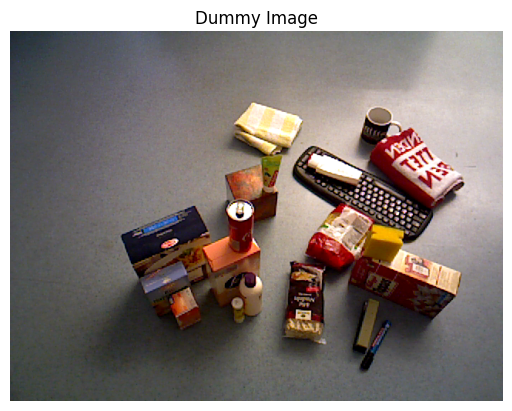

In [5]:
from matplotlib import pyplot as plt
import cv2
image_file = "images/boxes_with_sponge.png"
# load image as np array
dummy_image = cv2.imread(image_file)
def show_image(image, title="Image"):
	plt.imshow(image[:,:,::-1])  # Convert BGR to RGB for display
	plt.title(title)
	plt.axis('off')
	plt.show()
show_image(dummy_image, "Dummy Image")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using default config file
base_model_detections [{'bbox': array([[439, 280],
       [587, 375]], dtype=int32), 'class': 'box', 'prob': 0.5683509707450867, 'id': 0}, {'bbox': array([[438, 250],
       [587, 375]], dtype=int32), 'class': 'box', 'prob': 0.27419835329055786, 'id': 1}, {'bbox': array([[458, 249],
       [512, 301]], dtype=int32), 'class': 'sponge', 'prob': 0.24274054169654846, 'id': 2}]


/home/arthur/Desktop/CMU/research/motorcortex/motor_cortex/motor_cortex/perception/open_vocab_perception_pipeline/src/open_perception/perception/detection_models.py:259: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  results = self.processor.post_process_grounded_object_detection(
/home/arthur/anaconda3/envs/open_perception/lib/python3.11/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


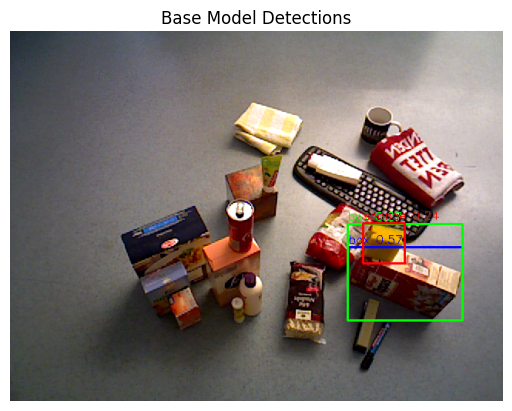

detections [{'bbox': array([[438, 250],
       [587, 375]], dtype=int32), 'class': 'box', 'prob': 0.27419835329055786, 'id': 1}]


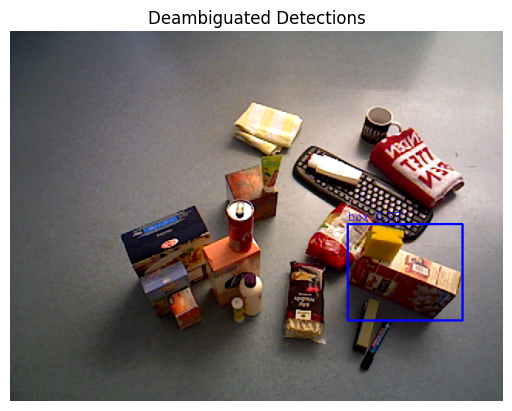

In [8]:
%load_ext autoreload
%autoreload 2
config  = load_config()

vlm_config = config.pipeline.perception.vlm_deambiguation
model_config = {
    "box_threshold": 0.15,
    "text_threshold": 0.15
}

detection_model = GroundingDinoModelHF(model_config=model_config)
detection_model = MultigranularDetectionModel(model_config={}, detection_model=detection_model)
model = VLMVerifier(
	vlm_config=vlm_config,
	model_config={},
	detection_model=detection_model
)
model.load_model()
model.update_classes(["box with sponge on top"])

# Running the base model without deambiguation
base_model_detections = model.detection_model.run_inference(dummy_image)
print("base_model_detections", base_model_detections)

overlay = dummy_image.copy()
elements = detections_to_elements(base_model_detections)
overlay = draw_elements_detections(overlay, elements)
show_image(overlay, title="Base Model Detections")

# Running with deambiguation
detections = model.run_inference(dummy_image)
print("detections", detections)

overlay = dummy_image.copy()
elements = detections_to_elements(detections)
overlay = draw_elements_detections(overlay, elements)
show_image(overlay, title="Deambiguated Detections")



In [11]:
from open_perception.utils.tests import recursive_filter_keys
recursive_filter_keys(model.last_messages, "image_url")

[{'role': 'system',
  'content': 'You are an AI assistant. Given a list of objects located in an image and the an image annotated with their respective bounding boxes, your task is to filter the detection to select only the objects that align closely with the input query. You must answer in json format with the following structure: {\n  "reasoning": "<input_query>",\n  "detections": ["<detection_label_1>", "<detection_label_2>", ...]\n} e.g. 1 query: "red button" output: {\n  "reasoning": "the image contains several button, but the one on top of seems to be red and is the one that better aligns with the query",\n  "detections": ["0"]\n} e.g. 2 query: "glass bottle" output: {\n  "reasoning": "the bottle on the right, with label \'0\', is blue and seems to be made of plastic. The one on the left, with label \'1\', is transparent and seems to be made of glass",\n  "detections": ["1"]\n} e.g. 3 query: "devices" output: {\n  "reasoning": "all the three detections seem to represent devices, 